In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats.distributions import uniform
from sklearn.preprocessing import PowerTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.model_selection import RandomizedSearchCV
import pickle

In [12]:
data = pd.read_csv('data.csv')
cat_cols = data.select_dtypes(include = 'object').columns
x = data.drop(cat_cols, axis = 1)
y = x.pop('AQI Value')

In [13]:
x.head()

,CO AQI Value,Ozone AQI Value,NO2 AQI Value,PM2.5 AQI Value
0,1,36,0,51
1,1,5,1,41
2,1,39,2,66
3,1,34,0,20
4,0,22,0,6


In [15]:
x.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23463 entries, 0 to 23462
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype
---  ------           --------------  -----
 0   CO AQI Value     23463 non-null  int64
 1   Ozone AQI Value  23463 non-null  int64
 2   NO2 AQI Value    23463 non-null  int64
 3   PM2.5 AQI Value  23463 non-null  int64
dtypes: int64(4)
memory usage: 733.3 KB


<Figure size 500x500 with 0 Axes>

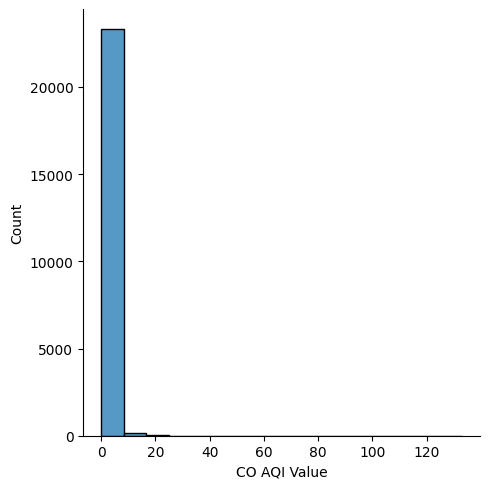

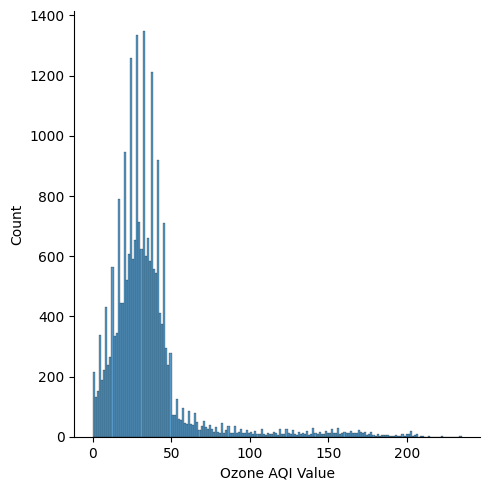

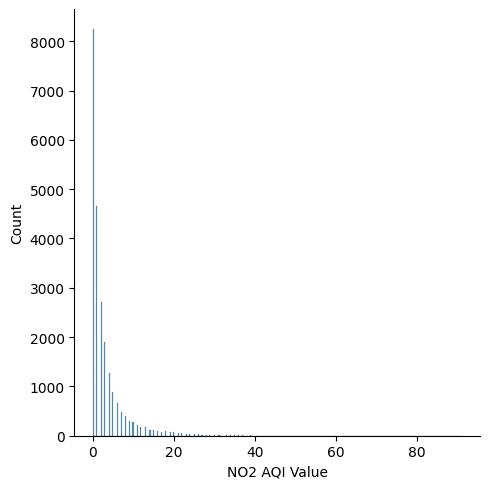

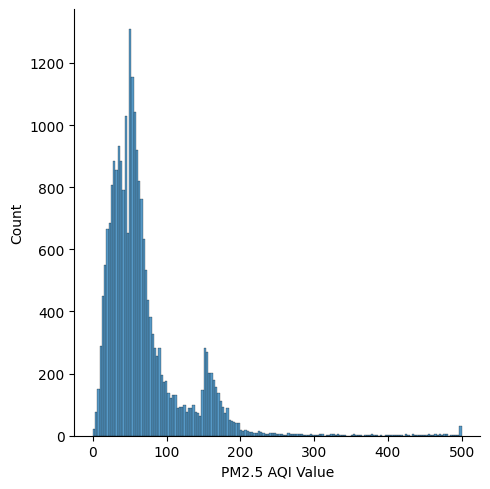

In [16]:
plt.figure(figsize = (5, 5))
sns.displot(x[x.columns[0]])
sns.displot(x[x.columns[1]])
sns.displot(x[x.columns[2]])
sns.displot(x[x.columns[3]])
plt.show()

training and testing

In [17]:
xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size = 0.2, random_state = 0)

In [18]:
estimators = {
    'LinearRegression': LinearRegression(),
    'SVR': SVR(),
    'XGBRegressor': XGBRegressor()
}

In [19]:
params_distribution = [
    {
        'model' : [estimators['LinearRegression']],
        'model__fit_intercept' : [True, False]
    },
    {
        'model' : [estimators['SVR']],
        'model__kernel' : ['linear', 'poly', 'rbf'],
        'model__gamma' : ['scale', 'auto'],
        'model__C' : uniform(loc = 0, scale = 3),
        'model__epsilon' : uniform(loc = 0, scale = 1)
    },
    {
        'model' : [estimators['XGBRegressor']],
        'model__n_estimators' : [int(x) for x in np.linspace(start = 50, stop = 500, num = 10)],
        'model__max_depth' : [int(x) for x in np.linspace(start = 1, stop = 10, num = 10)],
        'model__min_child' : [int(x) for x in np.linspace(start = 1, stop = 5, num = 5)],
        'model__learning_rate' : uniform(loc = 0, scale = 1)
    }
]

In [26]:
estimator_pipeline = Pipeline(
    [   ('power_transform', PowerTransformer()),
        ('model' , LinearRegression())
        ]
    )

In [27]:
random_search = RandomizedSearchCV(
    estimator = estimator_pipeline,
    param_distributions= params_distribution,
    n_iter = 10,
    cv = 5,
    scoring = 'r2',
    refit = 'r2',
    verbose = 4,
    n_jobs = -1
    )

In [28]:
random_search.fit(xtrain, ytrain)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [14:30:06] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "min_child" } are not used.

  warnings.warn(smsg, UserWarning)


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('power_transform',
                                              PowerTransformer()),
                                             ('model', LinearRegression())]),
                   n_jobs=-1,
                   param_distributions=[{'model': [LinearRegression()],
                                         'model__fit_intercept': [True, False]},
                                        {'model': [SVR()],
                                         'model__C': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7b1625f7e2f0>,
                                         'model__epsilon': <scipy.s...
                                                                n_estimators=None,
                                                                n_jobs=None,
                                                                num_parallel_tree=None,
                                                                random_state=None, ...)],
                                         'model__learning_rate': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7b1635a34460>,
                                         'model__max_depth': [1, 2, 3, 4, 5, 6,
                                                              7, 8, 9, 10],
                                         'model__min_child': [1, 2, 3, 4, 5],
                                         'model__n_estimators': [50, 100, 150,
                                                                 200, 250, 300,
                                                                 350, 400, 450,
                                                                 500]}],
                   refit='r2', scoring='r2', verbose=4)

In [29]:
print(random_search.best_estimator_)

Pipeline(steps=[('power_transform', PowerTransformer()),
                ('model',
                 XGBRegressor(base_score=None, booster=None, callbacks=None,
                              colsample_bylevel=None, colsample_bynode=None,
                              colsample_bytree=None, device=None,
                              early_stopping_rounds=None,
                              enable_categorical=False, eval_metric=None,
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None,
                              learning_rate=0.902424961509815, max_bin=None,
                              max_cat_threshold=None, max_cat_to_onehot=None,
                              max_delta_step=None, max_depth=2, max_leaves=None,
                              min_child=5, min_child_weight=None, missing=nan,
                              monotone_constraints=None, m

In [30]:
preds = random_search.best_estimator_.predict(xtest)
print(r2_score(ytest, preds))

0.9912878274917603


In [32]:
with open('model.pkl', 'wb') as file:
  pickle.dump(random_search.best_estimator_ , file)

print('Model saved to model.pkl')

Model saved to model.pkl
